In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
from importlib import reload
import seaborn as sns

/scratch/v45/dr4292/tmp/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /jobfs/132828946.gadi-pbs/matplotlib-h0pytrm3 because there was an issue with the default path (/scratch/v45/dr4292/tmp/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import os, sys

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import constants
import toe_constants as toe_const
import time_of_emergence_calc as toe
import time_of_emergence_data_analysis as toe_data_an
toe_calc = toe
import utils

logger = utils.get_notebook_logger()

In [4]:
from dask.distributed import Client
# client.close()
client = Client(threads_per_worker=1, n_workers=50)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:33137
 -   dashboard at:        /proxy/43977/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:34349'


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43977 instead
  warnings.warn(


 -         Start Nanny at: 'tcp://127.0.0.1:37585'
 -         Start Nanny at: 'tcp://127.0.0.1:38141'
 -         Start Nanny at: 'tcp://127.0.0.1:38893'
 -         Start Nanny at: 'tcp://127.0.0.1:41831'
 -         Start Nanny at: 'tcp://127.0.0.1:44497'
 -         Start Nanny at: 'tcp://127.0.0.1:40369'
 -         Start Nanny at: 'tcp://127.0.0.1:41175'
 -         Start Nanny at: 'tcp://127.0.0.1:40143'
 -         Start Nanny at: 'tcp://127.0.0.1:42249'
 -         Start Nanny at: 'tcp://127.0.0.1:35907'
 -         Start Nanny at: 'tcp://127.0.0.1:40203'
 -         Start Nanny at: 'tcp://127.0.0.1:38863'
 -         Start Nanny at: 'tcp://127.0.0.1:32959'
 -         Start Nanny at: 'tcp://127.0.0.1:37349'
 -         Start Nanny at: 'tcp://127.0.0.1:45039'
 -         Start Nanny at: 'tcp://127.0.0.1:44083'
 -         Start Nanny at: 'tcp://127.0.0.1:33123'
 -         Start Nanny at: 'tcp://127.0.0.1:36291'
 -         Start Nanny at: 'tcp://127.0.0.1:36841'
 -         Start Nanny at: 'tcp

<Client: 'tcp://127.0.0.1:33137' processes=50 threads=50, memory=248.00 GiB>

<h1 style='color:yellow'> Opening Data </h1>

In [5]:
CHUNK_DICT = {
    'best': {'time':-1, 'lat':180//3},
    'era5': {'time':-1, 'lon':1440//12, 'lat':-1}
}

In [6]:
def open_files_datatree(fname_dict, tree_name: str, chunks='auto', **kwargs):
    """
    Opens multiple NetCDF files and organizes them into a DataTree.

    Parameters:
    - fname_dict (dict): Dictionary where keys are names and values are file paths.
    - tree_name (str): Name for the root of the DataTree.
    - **kwargs: Additional keyword arguments passed to `xr.open_dataset`.

    Returns:
    - xr.DataTree: A DataTree object containing the datasets.
    """
    data_tree_dict = {}
    for name, path in fname_dict.items():
        if chunks == 'dataset': chunks = CHUNK_DICT.get('era5' if 'era5' in name else 'best')
        ds = xr.open_dataset(path, **kwargs).chunk(chunks)
        ds.attrs['name'] = name
        dt = xr.DataTree(ds, name=name)
        data_tree_dict[name] = dt
        

    tree = xr.DataTree(name=tree_name, children=data_tree_dict)
    return tree

In [7]:
np.array(toe_const.YearRange)

array([<YearRange.MODERN_PERIOD: (1959, 1989)>,
       <YearRange.MID_20TH_CENTURY: (1929, 1959)>,
       <YearRange.EARLY_20TH_CENTURY: (1899, 1929)>,
       <YearRange.ERA5_START: (1940, 1970)>], dtype=object)

In [8]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.ERA5_START
# base_period, base_period.start, base_period.end
base_period_string = str(base_period.value).replace(', ', '_')
base_period_string, base_period

('(1940_1970)', <YearRange.ERA5_START: (1940, 1970)>)

In [9]:
# Get just the files that have the string 
all_files = os.listdir(constants.TOE_SAVE_DIR)
files = np.array([f for f in all_files if base_period_string in f])
files.shape

(7,)

In [10]:
files = [
    'best_tas_(1940_1970)',
    'era5_2t_(1940_1970)',
    'era5_tx99count_(1940_1970)',
    'era5_tx99p9count_(1940_1970)'
]
 # 'era5_rx1d_(1940_1970)'

In [11]:
os.listdir(os.path.join(constants.TOE_SAVE_DIR, files[1]))

['data.zarr', 'toe_metrics.zarr', 'data_availability_mask.zarr', 'signal.zarr']

In [12]:
class FileNameManager:
    def __init__(self, file_names: list, root_path: str):
        """
        Initialize the FileNameManager with a list of file names and a root path.

        Parameters:
        - file_names (list): List of file name strings.
        - root_path (str): The root directory path.
        """
        self.file_names = file_names
        self.root_path = root_path

    def generate_dict(self, fname: str) -> dict:
        """
        Generate a dictionary mapping a simplified name (from file_names) to full paths.

        Parameters:
        - fname (str): File name to be appended to each directory.

        Returns:
        - dict: Dictionary with simplified names as keys and full file paths as values.
        """
        return {
            f.split('(')[0].rstrip('_ ').strip(): os.path.join(self.root_path, f, fname)
            for f in self.file_names
        }


In [13]:
# files = [f for f in files if 'access_ssp585_r10i1p1f1_pr_QSJUN_(1959_1989' not in f]
# files

In [14]:
base_file_manager = FileNameManager(files, constants.TOE_SAVE_DIR) #+ '/error')

In [15]:
fname_metric_dict = base_file_manager.generate_dict('toe_metrics.zarr')
fname_signal_dict = base_file_manager.generate_dict('signal.zarr')
fname_data_dict = base_file_manager.generate_dict('data.zarr')
data_availability_mask_dict = base_file_manager.generate_dict('data_availability_mask.zarr')

fname_data_dict

{'best_tas': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_(1940_1970)/data.zarr',
 'era5_2t': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_2t_(1940_1970)/data.zarr',
 'era5_tx99count': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tx99count_(1940_1970)/data.zarr',
 'era5_tx99p9count': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tx99p9count_(1940_1970)/data.zarr'}

In [16]:
%%time
toe_metric_tree = open_files_datatree(fname_metric_dict, 'data', engine='zarr', use_cftime=True, chunks='dataset')

CPU times: user 8.17 s, sys: 2.91 s, total: 11.1 s
Wall time: 15.4 s


In [17]:
data_tree = open_files_datatree(fname_data_dict, 'data', engine='zarr', use_cftime=True, chunks='dataset')

In [18]:
signal_tree = open_files_datatree(fname_signal_dict, 'signal', engine='zarr', use_cftime=True, chunks='dataset')

In [19]:
data_availability_tree = open_files_datatree(data_availability_mask_dict, 'data_availability_mask', 
                                             engine='zarr', use_cftime=True)

In [20]:
list(toe_metric_tree)

['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']

In [21]:
toe_metric_tree.era5_tx99count.frac.chunk()

<xarray.DataArray 'frac' (lat: 721, lon: 1440, time: 54)> Size: 449MB
dask.array<xarray-frac, shape=(721, 1440, 54), dtype=float64, chunksize=(60, 1440, 54), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) object 432B 1955-12-31 00:00:00 ... 2008-12-31 00:00:00
Attributes:
    bmax:        358.0
    bmin:        0.0
    bw_method:   0.2
    long_name:   Fractional Geometric Area
    num_points:  1000
    window:      30

In [22]:
toe_metric_tree

<xarray.DataTree 'data'>
Group: /
├── Group: /best_tas
│       Dimensions:          (time: 55, lat: 180, lon: 360)
│       Coordinates:
│         * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
│         * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
│         * time             (time) object 440B 1955-12-31 00:00:00 ... 2009-12-31 00...
│       Data variables:
│           frac             (time, lat, lon) float64 29MB dask.array<chunksize=(55, 60, 360), meta=np.ndarray>
│           hd               (time, lat, lon) float64 29MB dask.array<chunksize=(55, 60, 360), meta=np.ndarray>
│           ks               (time, lat, lon) float64 29MB dask.array<chunksize=(55, 60, 360), meta=np.ndarray>
│           perkins          (time, lat, lon) float64 29MB dask.array<chunksize=(55, 60, 360), meta=np.ndarray>
│           sn_hawkins_base  (lat, lon, time) float64 29MB dask.array<chunksize=(60, 360, 55), meta=np.ndarray>
│           sn_hawkins_full  (lat, lon, time) float64 29MB dask.array<chunksize=(60, 360, 55), meta=np.ndarray>
│           sn_lowess_base   (lat, lon, time) float64 29MB dask.array<chunksize=(60, 360, 55), meta=np.ndarray>
│           sn_lowess_full   (lat, lon, time) float64 29MB dask.array<chunksize=(60, 360, 55), meta=np.ndarray>
│           ttest            (time, lat, lon) float64 29MB dask.array<chunksize=(55, 60, 360), meta=np.ndarray>
│       Attributes:
│           long_name:  Kolmogorov-Smirnov
│           name:       best_tas
├── Group: /era5_2t
│       Dimensions:          (time: 55, lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│         * time             (time) object 440B 1955-12-31 00:00:00 ... 2009-12-31 00...
│       Data variables:
│           frac             (time, lat, lon) float64 457MB dask.array<chunksize=(55, 60, 1440), meta=np.ndarray>
│           hd               (time, lat, lon) float64 457MB dask.array<chunksize=(55, 60, 1440), meta=np.ndarray>
│           ks               (time, lat, lon) float64 457MB dask.array<chunksize=(55, 60, 1440), meta=np.ndarray>
│           perkins          (time, lat, lon) float64 457MB dask.array<chunksize=(55, 60, 1440), meta=np.ndarray>
│           sn_hawkins_base  (lat, lon, time) float64 457MB dask.array<chunksize=(60, 1440, 55), meta=np.ndarray>
│           sn_hawkins_full  (lat, lon, time) float64 457MB dask.array<chunksize=(60, 1440, 55), meta=np.ndarray>
│           sn_lowess_base   (lat, lon, time) float64 457MB dask.array<chunksize=(60, 1440, 55), meta=np.ndarray>
│           sn_lowess_full   (lat, lon, time) float64 457MB dask.array<chunksize=(60, 1440, 55), meta=np.ndarray>
│           ttest            (time, lat, lon) float64 457MB dask.array<chunksize=(55, 60, 1440), meta=np.ndarray>
│       Attributes:
│           long_name:  Kolmogorov-Smirnov
│           name:       era5_2t
├── Group: /era5_tx99count
│       Dimensions:          (lat: 721, lon: 1440, time: 54)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│         * time             (time) object 432B 1955-12-31 00:00:00 ... 2008-12-31 00...
│       Data variables:
│           frac             (lat, lon, time) float64 449MB dask.array<chunksize=(60, 1440, 54), meta=np.ndarray>
│           hd               (lat, lon, time) float64 449MB dask.array<chunksize=(60, 1440, 54), meta=np.ndarray>
│           ks               (lat, lon, time) float64 449MB dask.array<chunksize=(60, 1440, 54), meta=np.ndarray>
│           perkins          (lat, lon, time) float64 449MB dask.array<chunksize=(60, 1440, 54), meta=np.ndarray>
│           sn_hawkins_base  (lat, lon, time) float64 449MB dask.array<chunksize=(60, 1440, 54), meta=np.ndarray>
│         

<h1 style='color:yellow'>  Calculations </h1>

<h2 style='color:cyan'> ToE </h2>

In [23]:
def get_test_threshold(test: str) -> float:
    if test in toe_const.PVALUE_TESTS:
        return toe_const.PVALUE_THESHOLD1
    elif test in toe_const.OVERLAP_TESTS:
        return toe_const.OVERLAP_THRESHOLD
    elif 'sn' in test:
        return toe_const.SN_THRESHOLD1
    else:
        # Raise an error for unknown tests
        raise ValueError(f"Unknown test '{test}'. Please check the test name or add it"
                         "to the appropriate category.")

# Test that this function works for all tests
for test in list(toe_metric_tree[list(toe_metric_tree)[0]]): threshold = get_test_threshold(test); print(test, threshold)
    

frac 62
hd 62
ks 0.01
perkins 62
sn_hawkins_base 1
sn_hawkins_full 1
sn_lowess_base 1
sn_lowess_full 1
ttest 0.01


In [24]:
# def get_non_emergence_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
#     """
#     Determine the locations where specific tests do not emerge based on given thresholds.

#     Parameters:
#     ----------
#     toe_metrics_ds : xarray.Dataset
#         An xarray Dataset containing time series metrics for multiple tests.
#         Each variable in the dataset represents a test, and the final time 
#         step (time=-1) is used for comparison against the test's threshold.
    
#     logginglevel : str, optional
#         The logging level to use during execution. Default is 'ERROR'.
#         Possible values: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL'.

#     Returns:
#     -------
#     xarray.Dataset
#         A merged dataset where each variable indicates the non-emergence
#         condition for the corresponding test in `toe_metrics_ds`. The variables
#         are named based on their corresponding test names.

#     Notes:
#     -----
#     - For signal-to-noise ratio (SNR)-related tests (e.g., test names containing "sn"), 
#       the non-emergence condition is defined as `np.abs(value) <= threshold`.
#     - For all other tests, the non-emergence condition is defined as `value >= threshold`.
#     """

#     # Adjust the logging level as per the specified parameter
#     utils.change_logginglevel(logginglevel)
    
#     to_concat = []  # List to store DataArrays for each test's non-emergence condition

#     for test in list(toe_metrics_ds):
#         # Retrieve the threshold for the current test
#         threshold = get_test_threshold(test)

#         # Determine the appropriate comparison function based on the tst type
#         # Use np.less_equal for "sn" tests and np.greater_equal for others
#         comp_func = np.less_equal if (('sn' in test) or ('hd' in test)) else np.greater_equal

#         # Apply the comparison function to determine non-emergence locations
#         # For "sn" tests: np.abs(value) <= threshold
#         # For others: value >= threshold
#         logger.info(f'{test=} - {threshold} - {comp_func=}')  # Log the test name and its threshold

#         does_not_emerge_da = comp_func(np.abs(toe_metrics_ds[test].isel(time=-1)), threshold)

#         # Append the resulting DataArray to the list for later merging
#         to_concat.append(does_not_emerge_da)

#     # Merge all individual non-emergence DataArrays into a single Dataset
#     does_not_emerge_ds = xr.merge(to_concat)

#     return does_not_emerge_ds

In [25]:
def get_permanent_exceedance_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the year of permanent exceedance for multiple tests in the dataset.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
    
    simulation_max : float
        The maximum simulation year. If a test exceeds this year, it is considered not emerged.

    Returns:
    -------
    xarray.Dataset
        A merged dataset containing the year of permanent exceedance for all tests.
    """
    utils.change_logginglevel(logginglevel)

    logger.debug(toe_metrics_ds)
        
    exceedance_list = []

    for test in toe_metrics_ds:
        # Retrieve the threshold dynamically
        threshold = get_test_threshold(test)

        # Determine the comparison function
        comp_func = np.greater_equal if (('sn' in test) or ('hd' in test)) else np.less
        logger.info(f'{test=} - {threshold=} - {comp_func}')

        # Apply absolute value for 'sn'-related tests
        data = np.abs(toe_metrics_ds[test]) if 'sn' in test else toe_metrics_ds[test]

        # Calculate permanent exceedance
        exceedance_da = toe.get_permanent_exceedance(data, threshold=threshold, comparison_func=comp_func)

        exceedance_list.append(exceedance_da)

    # Merge all exceedance results
    toe_ds = xr.merge(exceedance_list)
    return toe_ds


In [26]:
def check_for_null(ds):  return not ds.dims and not ds.data_vars

In [27]:
def sign_final_time(toe_metrics_ds): 
    if check_for_null(toe_metrics_ds): return
    da = xr.where(toe_metrics_ds.sn_lowess_full.isel(time=-1) > 0, 1, -1)
    da.name = 'sign'
    ds = da.to_dataset()
    return ds

In [28]:
from dask.distributed import wait

In [29]:
list(toe_metric_tree)

['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']

In [30]:
sign_tf_tree = toe_metric_tree.map_over_datasets(sign_final_time)

In [31]:
toe_tree = toe_metric_tree.map_over_datasets(get_permanent_exceedance_multi_metrics, 'INFO').compute()

 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=62 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='ttest' - threshold=0.01 - <ufunc 'less'>
 - test='frac' - threshold=62 - <ufunc 'less'>
 - test='hd' - threshold=62 - <ufunc 'greater_equal'>
 - test='ks' - threshold=0.01 - <ufunc 'less'>
 - test='perkins' - threshold=62 - <ufunc 'less'>
 - test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
 - test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>
 - test='ttest' - threshold=0.

In [32]:
def get_non_emergence(toe_ds): return xr.where(np.isnan(toe_ds), 1, 0)

In [33]:
# does_not_emerge_tree = toe_metric_tree.map_over_datasets(get_non_emergence_multi_metrics).compute()
does_not_emerge_tree = toe_tree.map_over_datasets(get_non_emergence).compute()

In [34]:
toe_tree

<xarray.DataTree 'data'>
Group: /
├── Group: /best_tas
│       Dimensions:          (lat: 180, lon: 360)
│       Coordinates:
│         * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
│         * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
│       Data variables:
│           frac             (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
│           hd               (lat, lon) float64 518kB nan nan nan nan ... nan nan nan
│           ks               (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
│           perkins          (lat, lon) float64 518kB nan nan ... 1.997e+03 1.997e+03
│           sn_hawkins_base  (lat, lon) float64 518kB nan nan nan ... 1.99e+03 1.99e+03
│           sn_hawkins_full  (lat, lon) float64 518kB nan nan ... 1.991e+03 1.991e+03
│           sn_lowess_base   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
│           sn_lowess_full   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
│           ttest            (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
│       Attributes:
│           bmax:        23.400606155395508
│           bmin:        -7.221845626831055
│           bw_method:   0.2
│           long_name:   Fractional Geometric Area
│           num_points:  1000
│           window:      30
├── Group: /era5_2t
│       Dimensions:          (lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│       Data variables:
│           frac             (lat, lon) float64 8MB nan nan nan ... 1.983e+03 1.983e+03
│           hd               (lat, lon) float64 8MB nan nan nan ... 1.991e+03 1.991e+03
│           ks               (lat, lon) float64 8MB nan nan nan ... 1.983e+03 1.983e+03
│           perkins          (lat, lon) float64 8MB 1.973e+03 1.973e+03 ... 1.978e+03
│           sn_hawkins_base  (lat, lon) float64 8MB nan nan nan ... 1.983e+03 1.983e+03
│           sn_hawkins_full  (lat, lon) float64 8MB nan nan nan ... 1.985e+03 1.985e+03
│           sn_lowess_base   (lat, lon) float64 8MB 1.978e+03 1.978e+03 ... 1.979e+03
│           sn_lowess_full   (lat, lon) float64 8MB 1.981e+03 1.981e+03 ... 1.981e+03
│           ttest            (lat, lon) float64 8MB 1.973e+03 1.973e+03 ... 1.977e+03
│       Attributes:
│           bmax:        10.052776282274351
│           bmin:        -7.998153018104404
│           bw_method:   0.2
│           long_name:   Fractional Geometric Area
│           num_points:  1000
│           window:      30
├── Group: /era5_tx99count
│       Dimensions:          (lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│       Data variables:
│           frac             (lat, lon) float64 8MB 1.994e+03 1.994e+03 ... 1.985e+03
│           hd               (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           ks               (lat, lon) float64 8MB 1.995e+03 1.995e+03 ... 1.985e+03
│           perkins          (lat, lon) float64 8MB 1.996e+03 1.996e+03 ... nan nan
│           sn_hawkins_base  (lat, lon) float64 8MB 2.001e+03 2.001e+03 ... nan nan
│           sn_hawkins_full  (lat, lon) float64 8MB 2.006e+03 2.006e+03 ... nan nan
│           sn_lowess_base   (lat, lon) float64 8MB 2.003e+03 2.003e+03 ... nan nan
│           sn_lowess_full   (lat, lon) float64 8MB nan nan nan ... 1.986e+03 1.986e+03
│           ttest            (lat, lon) float64 8MB 1.995e+03 1.995e+03 ... 1.984e+03
│       Attributes:
│           bmax:        358.0
│           bmin:        0.0
│           bw_method:   0.2
│           long_name:   Fractional Geometric Area
│           num_points:  1000
│           window:      30
└── Group: /era5_tx99p9count
        Dimensions:          (lat

In [35]:
list(toe_tree)

['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']

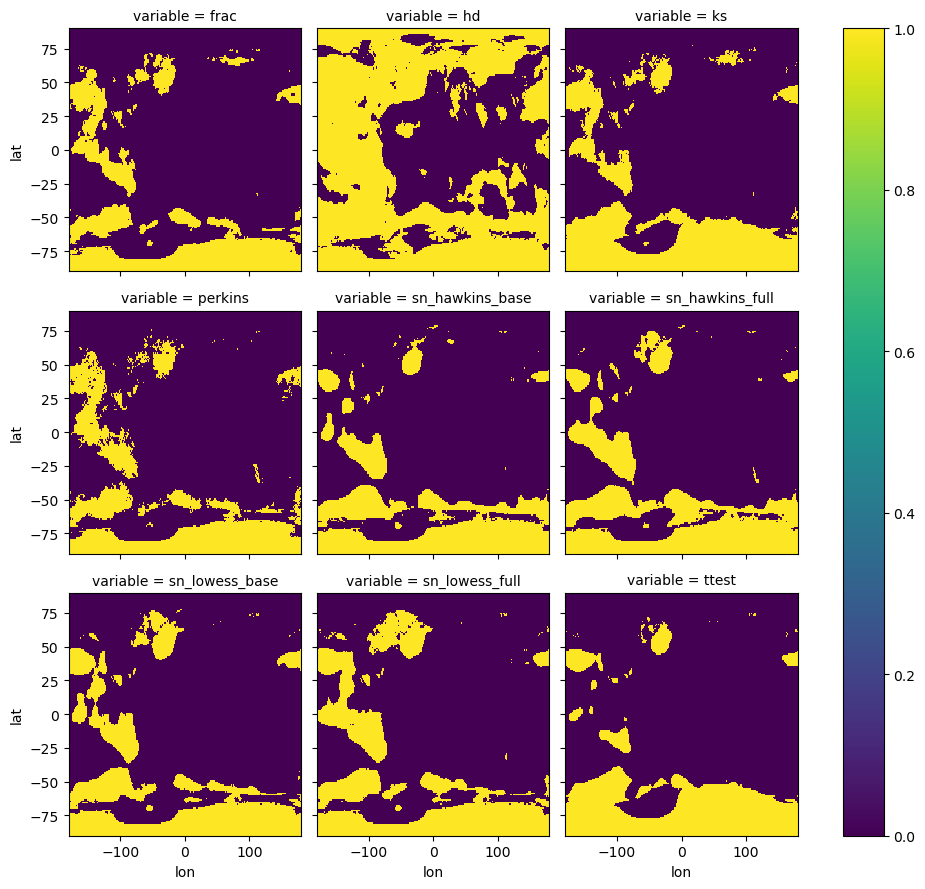

In [36]:
does_not_emerge_tree.best_tas.to_dataset().to_array().plot(col='variable', col_wrap=3)

In [37]:
list(sign_tf_tree)

['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']

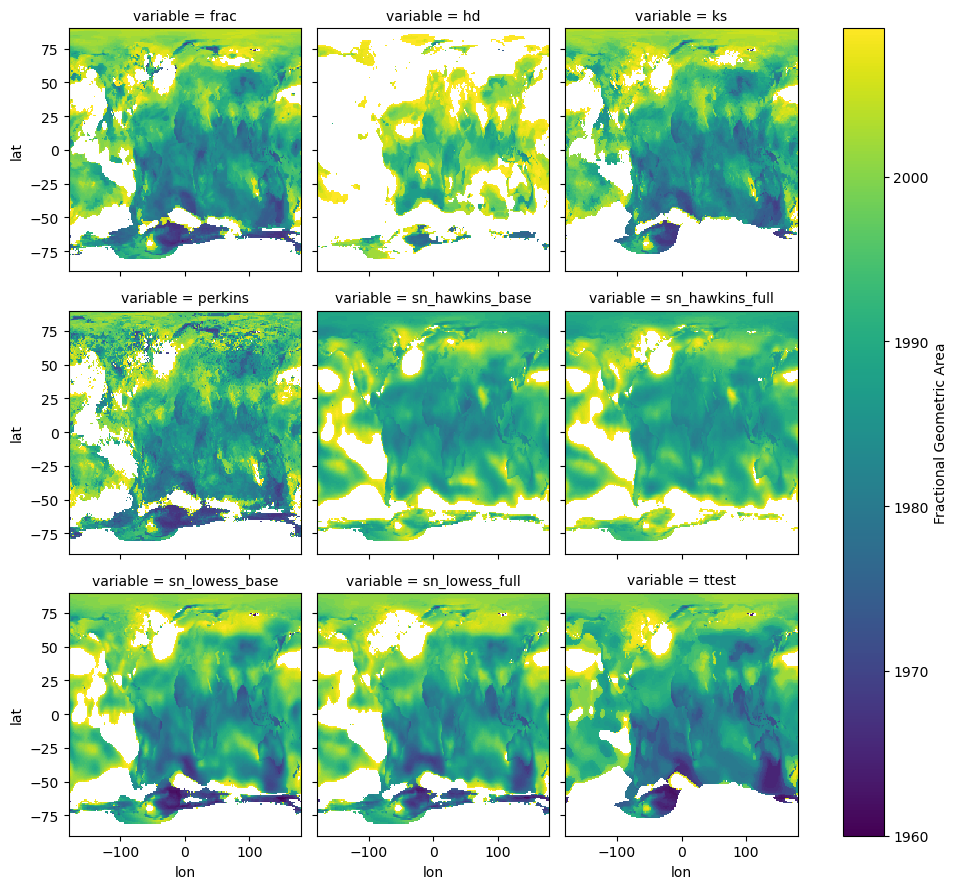

In [38]:
toe_tree.best_tas.to_dataset().to_array().plot(col='variable', col_wrap=3)

<h2 style='color:cyan'> Time Series </h2>

In [39]:
def percent_emerged(toe_metric_ds, toe_ds, does_not_emerge_ds, return_all=False):
    # Check for null input
    if check_for_null(toe_metric_ds): return

    # print(toe_metric_ds, toe_ds, sep='\n---\n')

    # Ensure proper handling of xarray objects
    if not isinstance(toe_metric_ds, (xr.Dataset, xr.DataArray)):
        raise TypeError(f"Expected xarray.Dataset or xarray.DataArray, got {type(toe_metric_ds)}")
    
    # Ensure time dimension is valid
    if 'time' not in toe_metric_ds.dims or not hasattr(toe_metric_ds.time, 'dt'):
        raise ValueError("The 'time' dimension is missing or not a datetime array in toe_metric_ds.")

    # Apply binary emergence calculation
    binary_emergence_ds = xr.apply_ufunc(
        toe_data_an.calculate_returned_binary_ds,
        toe_metric_ds,
        toe_ds,
        toe_metric_ds.time.dt.year.values,
        input_core_dims=[['time'], [], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert values to binary (1 or 0)
    binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
    # Only return where the dataset does emerge (seems to be issue for some reason)
    binary_emergence_ds = binary_emergence_ds.where(does_not_emerge_ds == 0)
    
    # Compute weights and percentage emergence
    only_1s_ds = xr.ones_like(binary_emergence_ds.isel(time=0))
    weights = toe_data_an.compute_weights(binary_emergence_ds)
    
    emergence_time_series_ds = toe_data_an.percentage_lat_lons(
        binary_emergence_ds, only_1s_ds, weights
    )

    if return_all: return emergence_time_series_ds, binary_emergence_ds, only_1s_ds
    
    return emergence_time_series_ds


In [40]:
ets_ds, be_ds, oo_ds = percent_emerged(
    toe_metric_tree.best_tas.to_dataset(),
    toe_tree.best_tas.to_dataset(),
    does_not_emerge_tree.best_tas.to_dataset(),
    return_all=True)

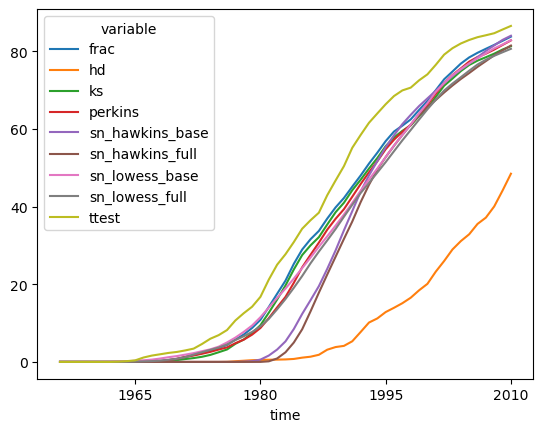

In [41]:
ets_ds.to_array().plot(hue='variable');

In [42]:
emergence_time_series_tree = xr.map_over_datasets(percent_emerged,
                                                  toe_metric_tree,
                                                  toe_tree,
                                                  does_not_emerge_tree
                                                 ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 247.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


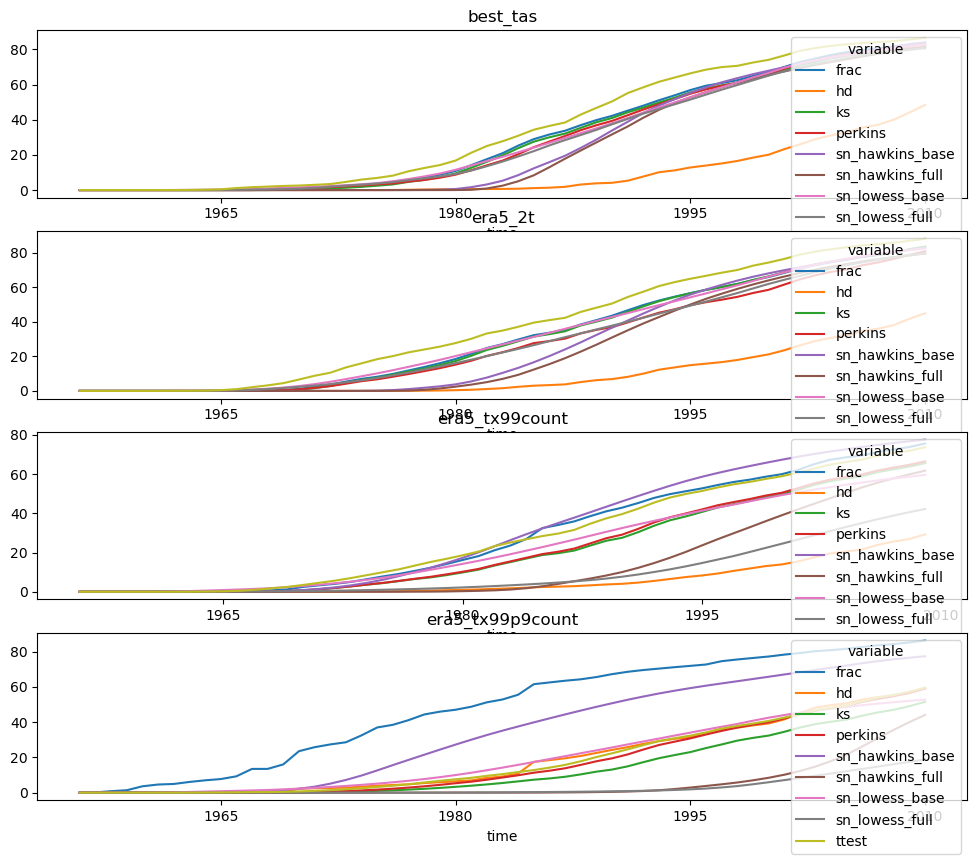

In [43]:
fig = plt.figure(figsize=(12, 10))

n_rows = len(emergence_time_series_tree)

for num, var in enumerate(emergence_time_series_tree):
    
    da = emergence_time_series_tree[var].to_dataset().to_array()

    ax = fig.add_subplot(n_rows, 1, num+1)
    da.plot(ax=ax, hue='variable')
    ax.set_title(var)

<h2 style='color:cyan'> Emergence cross values </h2>

In [201]:
from itertools import permutations
from dataclasses import dataclass

In [214]:
@dataclass(frozen=True)
class MetricPair:
    metric: str
    toe: str

In [265]:
def val_of_x_at_toe_of_y(toe_metric_da, toe_da):
    """
    Calculate the value of a metric (X) at the time of emergence (TOE) for a given dataset.

    Parameters
    ----------
    toe_metric_da : xarray.DataArray
        The data array containing the metric (X) time series from which the value at the TOE is calculated.
        It should have a 'time' dimension.
    toe_da : xarray.DataArray
        The data array representing the year of emergence (TOE). This defines the time point for which
        the value of the metric is calculated.
    
    Returns
    -------
    xarray.DataArray
        A DataArray containing the value of the metric at the time of emergence.
    """
    
    toe_x_at_y = xr.apply_ufunc(
        toe_data_an.find_value_at_emergence_arg,
        toe_metric_da, # Time series
        toe_da, # Year of emergence
        kwargs = {'time_years': toe_metric_da.time.dt.year.values},
        input_core_dims = [['time'], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float])
    
    return toe_x_at_y

In [325]:
def all_perms_x_at_y_emergence(toe_metric_ds, toe_ds):
    """
    Generate a dataset of metric values (X) at the time of emergence (TOE) for all valid metric-TOE pairs.

    Parameters
    ----------
    toe_metric_ds : xarray.Dataset
        A dataset containing various metrics (X) as time series data.
    toe_ds : xarray.Dataset
        A dataset containing the time of emergence (TOE) for corresponding metrics.

    Returns
    -------
    xarray.Dataset
        A dataset where each variable represents a metric value (X) at its corresponding time of emergence (TOE).
        The variable names are in the format '<metric>_at_<toe>_emergence'.
        Returns None if `toe_metric_ds` contains null values.
    """
    # Check if the input dataset contains null values; exit early if so
    if check_for_null(toe_metric_ds): 
        return
    
    x_at_y_emergence_dict = {}
    for pair in filtered_pairs:
        name = f'{pair.metric}_at_{pair.toe}_emergence'
        x_at_y_emergence_da = val_of_x_at_toe_of_y(
            toe_metric_ds[pair.metric],  # Metric time series
            toe_ds[pair.toe]            # Year of emergence
        ).compute()  # Compute the result to ensure it's not lazy (useful for Dask arrays)

        x_at_y_emergence_dict[name] = x_at_y_emergence_da # pari old key
    x_at_y_emergence_ds = xr.Dataset(x_at_y_emergence_dict)
    
    return x_at_y_emergence_ds


In [241]:
td = val_of_x_at_toe_of_y(
    toe_metric_tree['best_tas'].to_dataset()['frac'],
    toe_tree['best_tas'].to_dataset()['ks']
).compute()

In [202]:
toe_data_an.find_value_at_emergence_arg

<function time_of_emergence_data_analysis.find_value_at_emergence_arg(arr: Union[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]], year_of_emergence: int, time_years: Union[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]]) -> float>

In [206]:
np.array(list(toe_tree['best_tas']))

array(['frac', 'hd', 'ks', 'perkins', 'sn_hawkins_base',
       'sn_hawkins_full', 'sn_lowess_base', 'sn_lowess_full', 'ttest'],
      dtype='<U15')

In [207]:
metrics = np.array(['frac', 'hd', 'ks', 'perkins', 'sn_lowess_base', 'sn_lowess_full', 'ttest'])

In [227]:
# Get the permutatoins of all metrics, but not when a is ttest or ks
filtered_pairs = [
    MetricPair(metric, toe)
    for metric, toe in permutations(metrics, 2)
    if metric not in {'ttest', 'ks'}
]

In [228]:
filtered_pairs[0]

MetricPair(metric='frac', toe='hd')

In [229]:
filtered_pairs[:3]

[MetricPair(metric='frac', toe='hd'),
 MetricPair(metric='frac', toe='ks'),
 MetricPair(metric='frac', toe='perkins')]

In [230]:
len(filtered_pairs)

30

In [ ]:
x_at_y_emergence_tree = xr.map_over_datasets(
    all_perms_x_at_y_emergence,
    toe_metric_tree,
    toe_tree
)

In [ ]:
x_at_y_emergence_tree

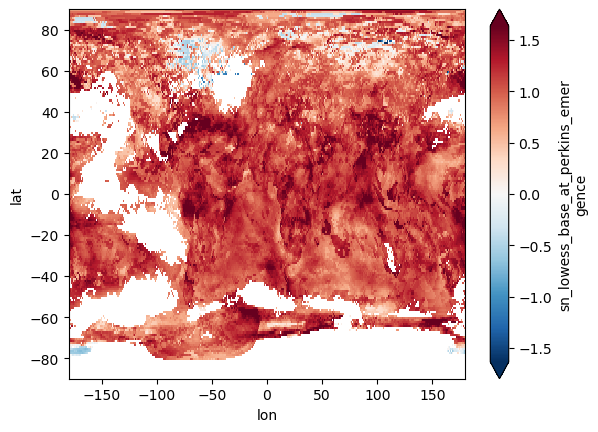

In [282]:
x_at_y_emergence_tree['best_tas'].to_dataset()['sn_lowess_base_at_perkins_emergence'].plot(robust=True)

In [279]:
x_at_y_emergence_tree['best_tas'].to_dataset().mean().to_array()

<xarray.DataArray (variable: 30)> Size: 240B
array([35.60006002, 60.98534293, 60.59495317, 61.20657376, 60.3857505 ,
       65.96414958, 40.63990198, 40.22433711, 40.59808191, 40.2745055 ,
       40.82738404, 35.88991127, 60.86777536, 36.5992955 , 61.29336215,
       61.38154475, 60.60105799, 66.13654364,  1.03333295,  1.9391895 ,
        1.03985874,  1.00569037,  1.07015769,  0.86971222,  0.99924339,
        1.85960695,  1.00390741,  0.97373938,  1.00039561,  0.83686396])
Coordinates:
  * variable  (variable) object 240B 'frac_at_hd_emergence' ... 'sn_lowess_fu...

<h1 style='color:cyan'> Plots</h1>

<h2 style='color:yellow'> Set-up </h2>

In [44]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [45]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [46]:
from dataclasses import dataclass

@dataclass
class PlotLevels:
    start: int
    stop: int
    step: int

    def generate_range(self):
        """Generate a numpy array based on the start, stop, and step."""
        return np.arange(self.start, self.stop, self.step)

In [47]:
LEVEL_TYPES = {
    'historical': PlotLevels(start=1970, stop=2015, step=5),
    'access':PlotLevels(start=1970, stop=2300, step=20)
}

PLOT_LEVELS = {
    item: LEVEL_TYPES['access'] if 'access' in item else LEVEL_TYPES['historical']
    for item in list(toe_tree)
}

PLOT_LEVELS

{'best_tas': PlotLevels(start=1970, stop=2015, step=5),
 'era5_2t': PlotLevels(start=1970, stop=2015, step=5),
 'era5_tx99count': PlotLevels(start=1970, stop=2015, step=5),
 'era5_tx99p9count': PlotLevels(start=1970, stop=2015, step=5)}

In [49]:
def create_discrete_colorbar(cmap, levels, cax, label, fontscale=1):
    """
    Create a discrete colorbar with the given colormap and levels.
    
    Args:
        cmap: Colormap to use.
        levels: Discrete levels (boundaries).
        cax: Colorbar axis.
        label: Label for the colorbar.
    """
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label(label, fontsize=16)
    cbar.ax.set_title(label, fontsize=12*fontscale, pad=20)
    # Scale y-tick labels' font size
    cbar.ax.tick_params(axis='y', labelsize=10 * fontscale)
    return cbar

<h2 style='color:yellow'> Plot lab </h2>

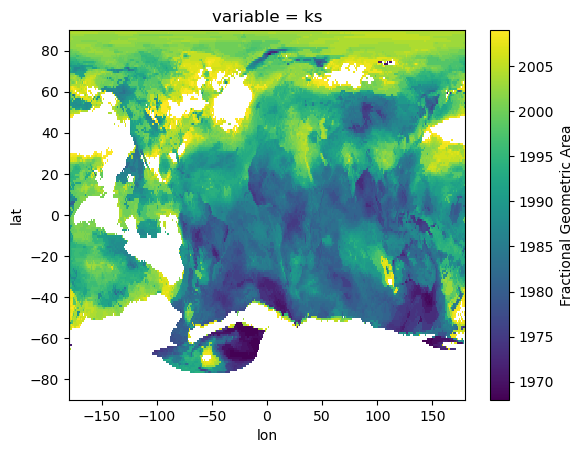

In [50]:
toe_tree['best_tas'].to_dataset().to_array().sel(variable='ks').plot()

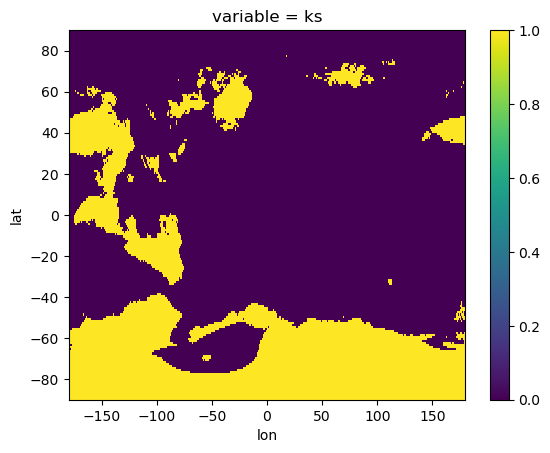

In [51]:
does_not_emerge_tree['best_tas'].to_dataset().to_array().sel(variable='ks').plot()

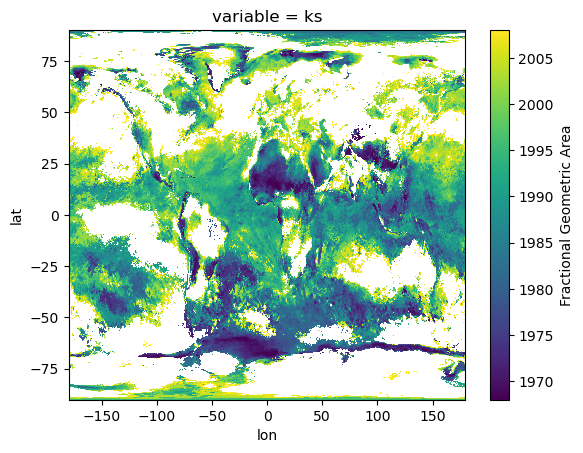

In [52]:
toe_tree['era5_tx99count'].to_dataset().to_array().sel(variable='ks').plot()

In [53]:
list(toe_tree)

['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']

In [54]:
toe_metrics_list = toe_tree[list(toe_tree)[0]]
toe_metrics_list

<xarray.DataTree 'best_tas'>
Group: /best_tas
    Dimensions:          (lat: 180, lon: 360)
    Coordinates:
      * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
      * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
    Data variables:
        frac             (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
        hd               (lat, lon) float64 518kB nan nan nan nan ... nan nan nan
        ks               (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
        perkins          (lat, lon) float64 518kB nan nan ... 1.997e+03 1.997e+03
        sn_hawkins_base  (lat, lon) float64 518kB nan nan nan ... 1.99e+03 1.99e+03
        sn_hawkins_full  (lat, lon) float64 518kB nan nan ... 1.991e+03 1.991e+03
        sn_lowess_base   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
        sn_lowess_full   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
        ttest            (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
    Attributes:
        bmax:        23.400606155395508
        bmin:        -7.221845626831055
        bw_method:   0.2
        long_name:   Fractional Geometric Area
        num_points:  1000
        window:      30

In [55]:
vars_of_interest = ['best_tas', 'era5_2t', 'era5_tx99count', 'era5_rx1d']

In [56]:
toe_tree = toe_tree.compute()
sign_tf_tree = sign_tf_tree.compute()

In [67]:
base_period.start

1940

In [91]:
toe_emergence_levels = PlotLevels(base_period.start+15, 2015, step=5).generate_range()
toe_emergence_levels

array([1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005,
       2010])

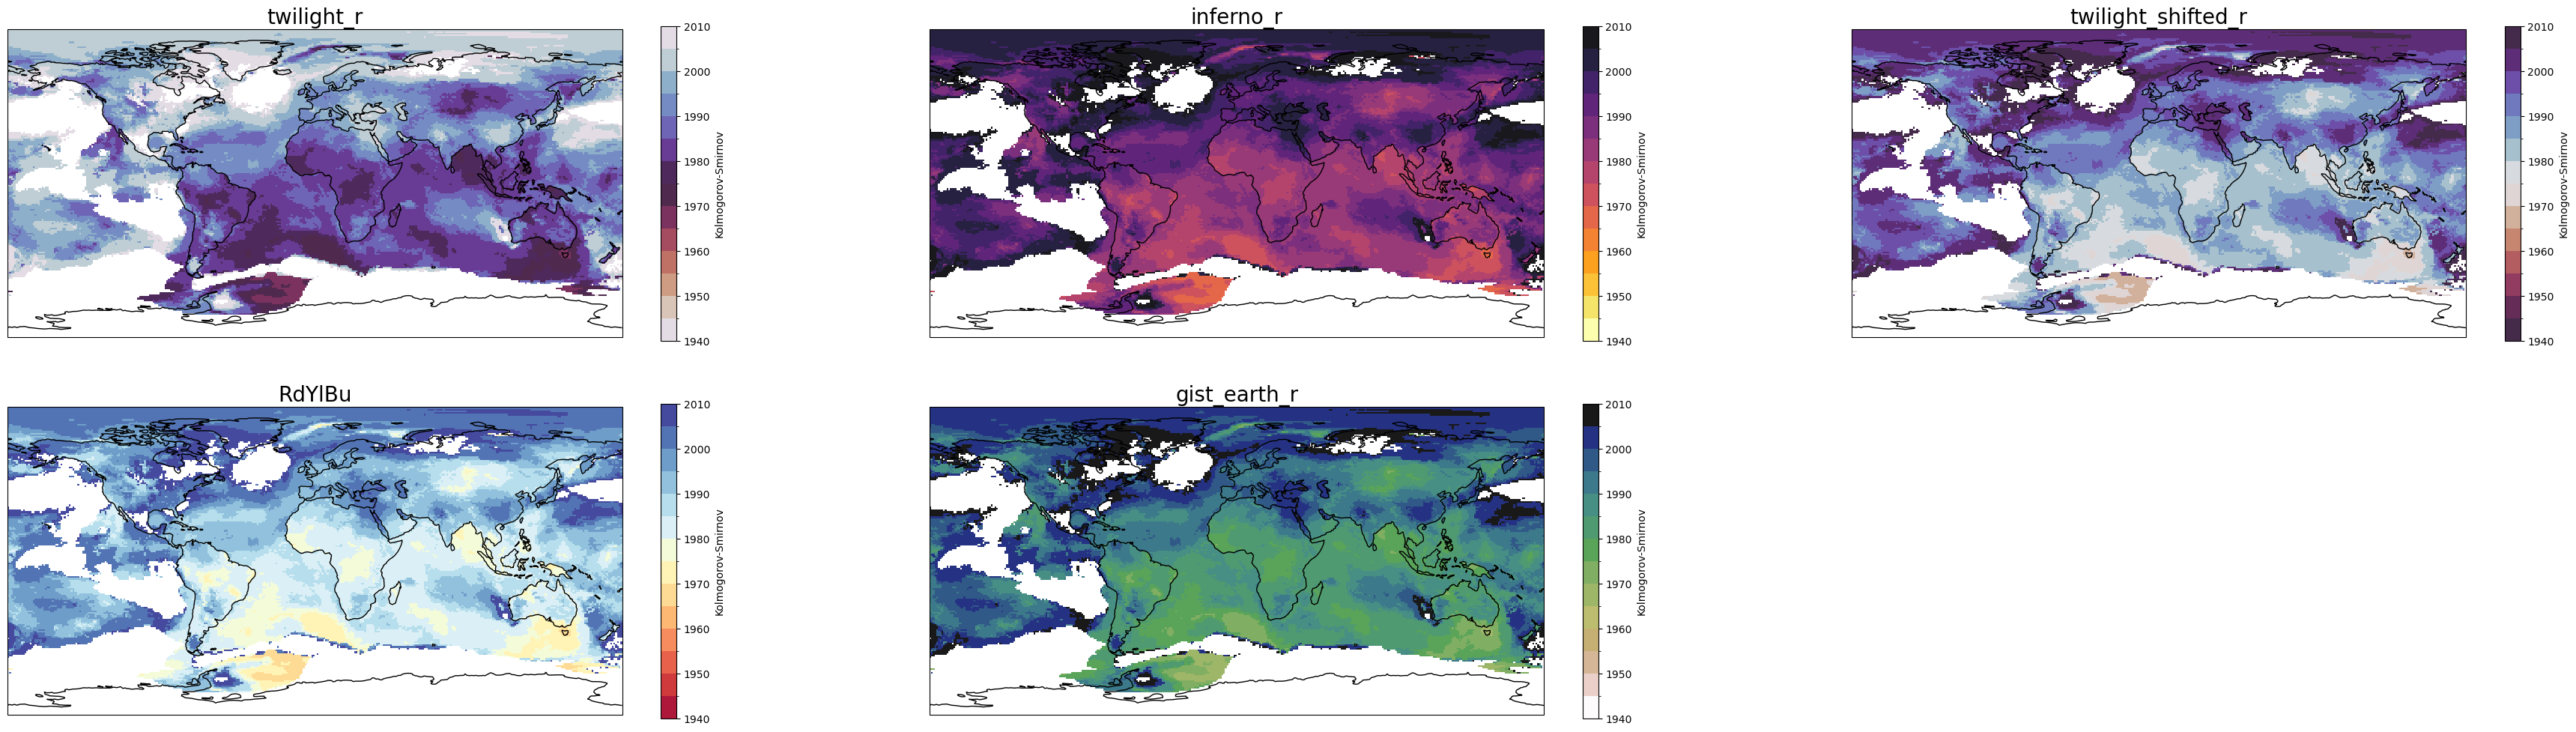

In [73]:
# colormap_list = plt.colormaps()
colormap_list = ['twilight_r', 'inferno_r', 'twilight_shifted_r', 'RdYlBu', 'gist_earth_r']
# Number of columns and rows for subplots
ncols = 3
nrows = int(np.ceil(len(colormap_list) / ncols))

# Adjust the figure size dynamically
fig = plt.figure(figsize=(ncols * 15, nrows *6))

for num, cmap in enumerate(colormap_list):
    # Calculate the subplot index
    row = num // ncols
    col = num % ncols
    ax = fig.add_subplot(nrows, ncols, num + 1, projection=ccrs.PlateCarree())
    
    toe_tree.best_tas.ks.plot(ax=ax, cmap=cmap, levels=toe_emergence_levels, alpha=0.9)
    
    ax.coastlines()
    ax.set_title(cmap, fontsize=20)  # Add colormap name as title

In [74]:
toe_metrics_list

<xarray.DataTree 'best_tas'>
Group: /best_tas
    Dimensions:          (lat: 180, lon: 360)
    Coordinates:
      * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
      * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
    Data variables:
        frac             (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
        hd               (lat, lon) float64 518kB nan nan nan nan ... nan nan nan
        ks               (lat, lon) float64 518kB nan nan ... 2.004e+03 2.004e+03
        perkins          (lat, lon) float64 518kB nan nan ... 1.997e+03 1.997e+03
        sn_hawkins_base  (lat, lon) float64 518kB nan nan nan ... 1.99e+03 1.99e+03
        sn_hawkins_full  (lat, lon) float64 518kB nan nan ... 1.991e+03 1.991e+03
        sn_lowess_base   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
        sn_lowess_full   (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
        ttest            (lat, lon) float64 518kB nan nan ... 2.001e+03 2.001e+03
    Attributes:
        bmax:        23.400606155395508
        bmin:        -7.221845626831055
        bw_method:   0.2
        long_name:   Fractional Geometric Area
        num_points:  1000
        window:      30

In [75]:
def hatch(ax, ds, **kwargs):
    invert = lambda ds: xr.where(ds, 0, 1)

    ds = invert(ds)
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, levels=[-1, 0, 1, 2], **kwargs)

not_stable_kwargs = dict(hatches=['', '////'], alpha=0, colors=None)

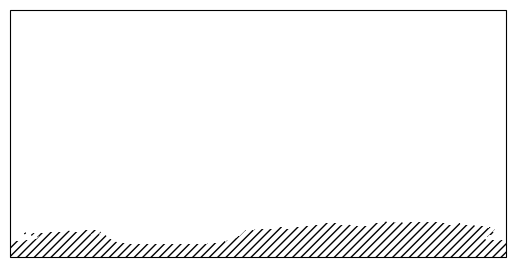

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, data_availability_tree.best_tas.to_dataset().to_array().squeeze(), **not_stable_kwargs)

In [77]:
np.array(list(toe_metrics_list))

array(['frac', 'hd', 'ks', 'perkins', 'sn_hawkins_base',
       'sn_hawkins_full', 'sn_lowess_base', 'sn_lowess_full', 'ttest'],
      dtype='<U15')

In [121]:
main_tests = ['sn_lowess_base', 'ks', 'ttest', 'perkins', 'frac', 'hd']

In [79]:
test_colors = {
    'sn_lowess_base': '#1f77b4',  # Blue
    'ks': '#ff7f0e',             # Orange
    'ttest': '#ffa34d',          # Light Orange (similar to ks but distinct)
    'perkins': '#2ca02c',        # Bright Green
    'frac': '#8bc34a',           # Lime Green (lighter and vibrant)
    'hd': '#556b2f',             # Olive Green (distinct and darker)
}


In [185]:
NAME_MAPPING = {
    'best_tas': 'BEST - SAT',
    'era5_2t': 'ERA5 -  SAT',
    'era5_tx99count': 'ERA5 - \n TX99Count',
    'era5_tx99p9count': 'ERA5 - \n TX99.9Count'
}

In [81]:
METRIC_MAP = {
 'sn_lowess_base': 'S/N Ratio \n(Base Noise)',
 'ks': 'Kolmogorov-\nSmirnov Test',
 'ttest': 'T-Test',
 'perkins': 'Perkins\nSkill Score',
 'frac': 'Fractional\nGeometric\nArea',
 'hd': 'Hellinger\nDistance'}

In [82]:
def percent_emerged_series(emergence_series_da, toe_metric_list: np.ndarray = None, time=None, ax=None, legend=True, fontscale=1):
    """
    Plots percent emerged series for specified metrics.

    Parameters:
    - emergence_series_da: xarray.DataArray containing emergence data for different metrics.
    - toe_metric_list: List or array of metrics to plot. Defaults to all metrics in the DataArray.
    - time: Time values to use for plotting. Defaults to `emergence_series_da.time.values`.
    - fig: Matplotlib figure object. If None, a new figure and axis are created.

    Returns:
    - None
    """
    # Create figure and axis if not provided
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Use default time and metrics if not provided
    time = emergence_series_da.time.dt.year.values if time is None else time
    toe_metric_list = list(emergence_series_da) if toe_metric_list is None else toe_metric_list

    # Loop through metrics and plot
    for metric in toe_metric_list:
        # Get the color and label for the metric
        color = test_colors.get(metric, 'black')  # Default to black if not in the dictionary
        label = METRIC_MAP.get(metric, metric)  # Fallback to metric name if no conversion
        
        # Plot the data
        ax.plot(
            time, 
            emergence_series_da[metric].squeeze().values, 
            color=color, 
            label=label, 
            linewidth=3
        )

    # Customize the plot
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='y', labelsize=12*fontscale)
    ax.tick_params(axis='x', labelsize=12*fontscale)
    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-2, 102)
    ax.set_xticks(np.arange(*np.take(time, [0, -1]), 10))

    ax.set_xlim(np.take(time, [0, -1]))

    if legend: ax.legend(fontsize=14*fontscale, loc='upper left')


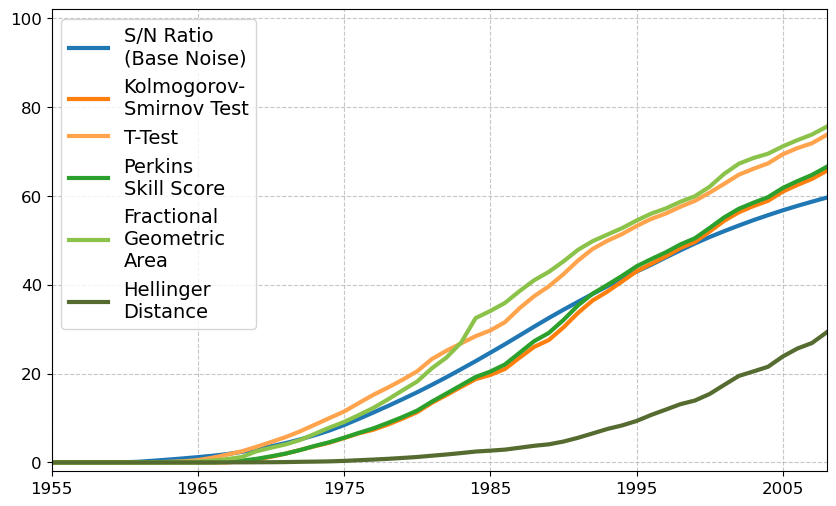

In [83]:
percent_emerged_series(emergence_time_series_tree.era5_tx99count.to_dataset(), main_tests)

In [88]:
toe_emergence_levels

array([1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990,
       1995, 2000, 2005, 2010])

, sn_lowess_base, ks, perkins, hd, sn_lowess_base, ks, perkins, hd, sn_lowess_base, ks, perkins, hd, sn_lowess_base, ks, perkins, hd

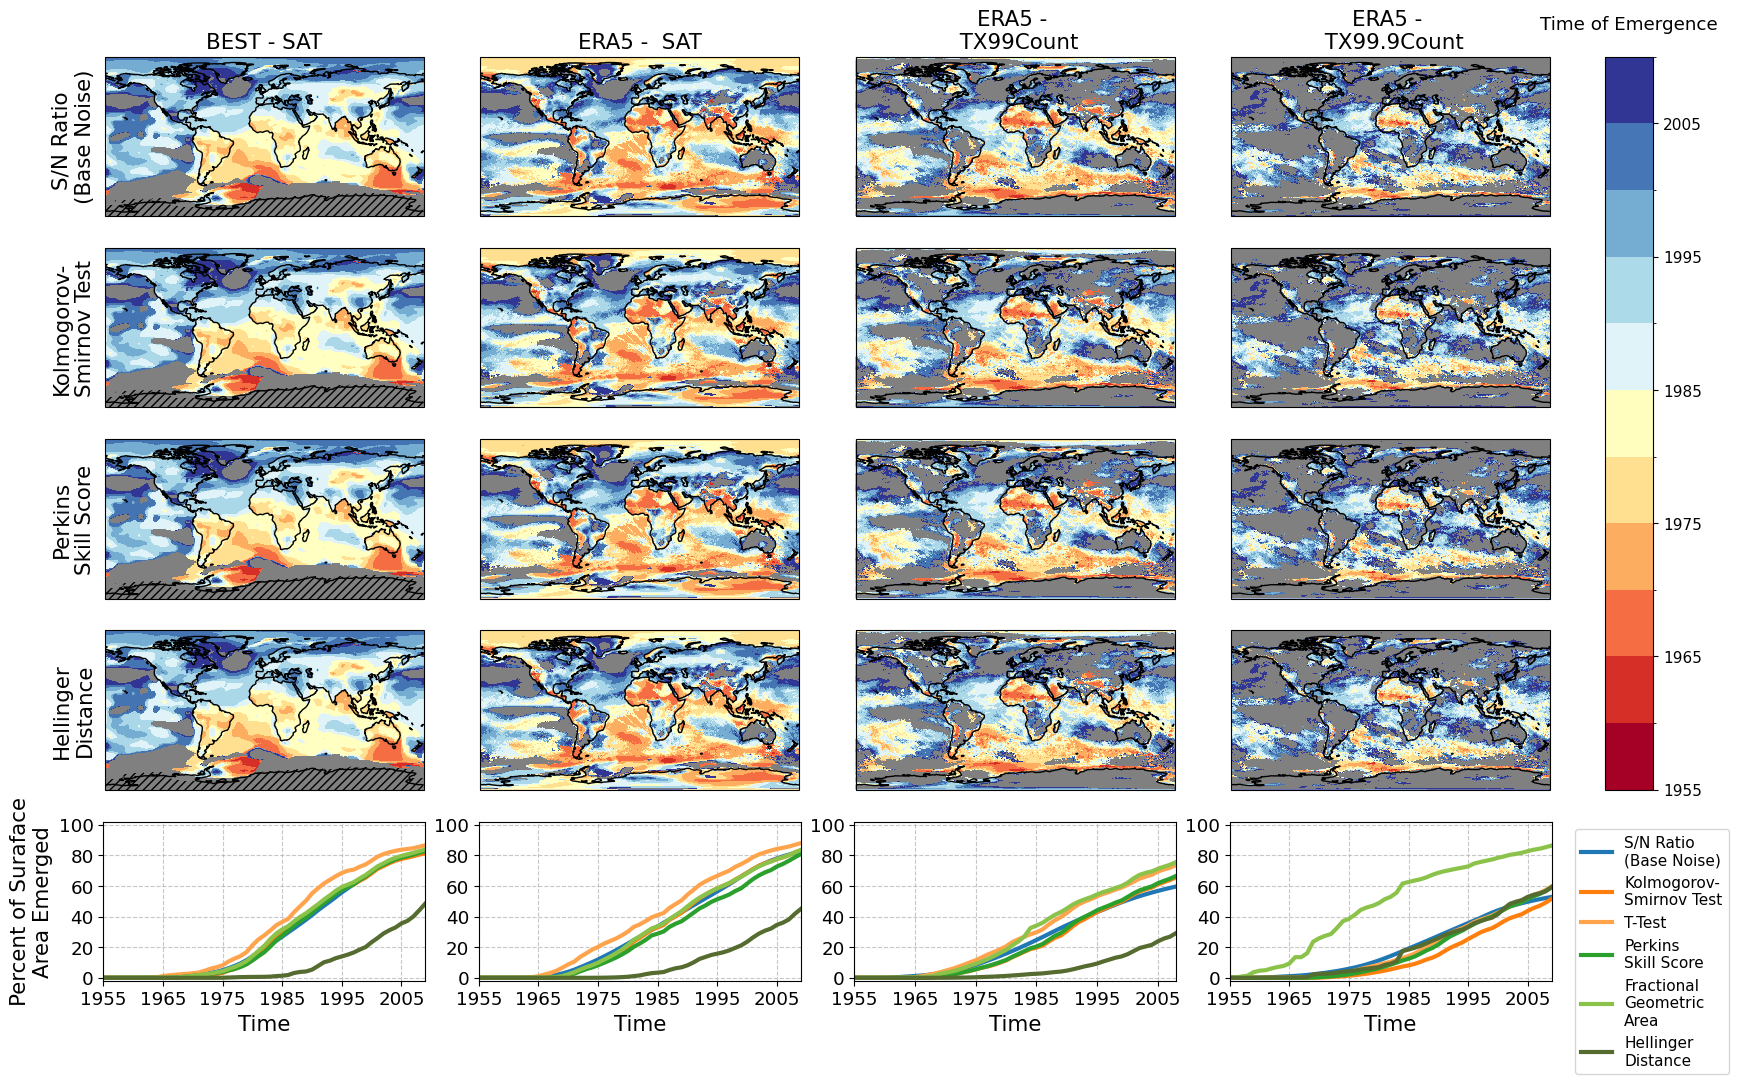

In [189]:
fontscale = 1.1

tests_subset_used = ['sn_lowess_base', 'ks', 'perkins', 'hd']
tests_var_used = ['best_tas', 'era5_2t', 'era5_tx99count', 'era5_tx99p9count']
cmap = plt.cm.RdYlBu


fig = plt.figure(figsize=(5*len(list(tests_var_used)), 3*len(tests_subset_used)))
gs  = gridspec.GridSpec(len(tests_subset_used)+1, len(tests_var_used) +1, 
                       width_ratios = [1] * len(tests_var_used) + [0.15])



axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in np.arange(len(tests_var_used))]
    for row in range(len(tests_subset_used))
])


bottom_axes = [fig.add_subplot(gs[-1, col]) for col in range(len(tests_var_used))]

for col,variable in enumerate(tests_var_used):
    # print(f'\n{variable=}')
    
    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):
        print(f', {metric}', end='')

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)
        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.plot(cmap=cmap, ax=ax, **toe_plot_kwargs)
        hatch(ax, data_availability_tree[variable].to_dataset().to_array().squeeze(), **not_stable_kwargs)

        ax.coastlines()

        if col == 0:  ax.annotate(
            METRIC_MAP.get(metric, metric),
            xy=(-0.1, 0.5), xycoords = 'axes fraction',
            rotation=90, ha='center', va='center', fontsize=14*fontscale)
        if row == 0: ax.set_title(NAME_MAPPING.get(variable, variable), fontsize=14*fontscale)

    # Adding in the time series
    bax = bottom_axes[col]
    percent_emerged_series(emergence_time_series_tree[variable].to_dataset(), main_tests, ax=bax, legend=False,
                          fontscale=fontscale)


for bax in bottom_axes: bax.set_xlabel("Time", fontsize=14*fontscale)
bottom_axes[0].set_ylabel("Percent of Suraface\nArea Emerged", fontsize=14*fontscale)
leg = bottom_axes[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=10*fontscale)
# leg = bottom_axes[-1].legend(ncol=len(tests_subset_used), bbox_to_anchor=(1, -.1), fontsize=10*fontscale)


cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:-1, -1], wspace=0)
cax = plt.subplot(cax_gs1[0])

# Create colorbars
cbar = create_discrete_colorbar(
    cmap, toe_emergence_levels, cax, 'Time of Emergence',fontscale=fontscale)

In [134]:
reload(toe_data_an)

<module 'time_of_emergence_data_analysis' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emergence_data_analysis.py'>

In [158]:
corr_restuls = {}
for branch in toe_tree:
    print(f'{branch}, ')
    corr_restuls[branch] = toe_data_an.xarray_data_var_pattern_correlation_all_combs(
        toe_tree[branch].to_dataset()[main_tests])
pattern_corr_tree = xr.DataTree.from_dict(corr_restuls)

best_tas, 
era5_2t, 
era5_tx99count, 
era5_tx99p9count, 


In [153]:
pattern_corr_tree

<xarray.DataTree>
Group: /
├── Group: /best_tas
│       Dimensions:          (index: 9)
│       Coordinates:
│         * index            (index) object 72B 'frac' 'hd' ... 'sn_lowess_full' 'ttest'
│       Data variables:
│           frac             (index) float64 72B nan 0.76 0.96 0.8 ... 0.88 0.88 0.88
│           hd               (index) float64 72B nan nan 0.77 0.69 ... 0.8 0.79 0.72
│           ks               (index) float64 72B nan nan nan 0.78 0.36 0.39 0.9 0.9 0.92
│           perkins          (index) float64 72B nan nan nan nan ... 0.24 0.75 0.75 0.71
│           sn_hawkins_base  (index) float64 72B nan nan nan nan nan 0.89 0.48 0.42 0.35
│           sn_hawkins_full  (index) float64 72B nan nan nan nan nan nan 0.47 0.49 0.38
│           sn_lowess_base   (index) float64 72B nan nan nan nan nan nan nan 0.94 0.9
│           sn_lowess_full   (index) float64 72B nan nan nan nan nan nan nan nan 0.9
│           ttest            (index) float64 72B nan nan nan nan nan nan nan nan nan
├── Group: /era5_2t
│       Dimensions:          (index: 9)
│       Coordinates:
│         * index            (index) object 72B 'frac' 'hd' ... 'sn_lowess_full' 'ttest'
│       Data variables:
│           frac             (index) float64 72B nan 0.66 0.94 0.82 ... 0.89 0.86 0.83
│           hd               (index) float64 72B nan nan 0.65 0.61 ... 0.72 0.73 0.61
│           ks               (index) float64 72B nan nan nan 0.81 0.41 0.43 0.9 0.9 0.88
│           perkins          (index) float64 72B nan nan nan nan 0.3 0.32 0.75 0.75 0.73
│           sn_hawkins_base  (index) float64 72B nan nan nan nan nan 0.9 0.51 0.48 0.39
│           sn_hawkins_full  (index) float64 72B nan nan nan nan nan nan 0.47 0.54 0.43
│           sn_lowess_base   (index) float64 72B nan nan nan nan nan nan nan 0.93 0.9
│           sn_lowess_full   (index) float64 72B nan nan nan nan nan nan nan nan 0.91
│           ttest            (index) float64 72B nan nan nan nan nan nan nan nan nan
├── Group: /era5_tx99count
│       Dimensions:          (index: 9)
│       Coordinates:
│         * index            (index) object 72B 'frac' 'hd' ... 'sn_lowess_full' 'ttest'
│       Data variables:
│           frac             (index) float64 72B nan 0.65 0.89 0.88 ... 0.8 0.64 0.85
│           hd               (index) float64 72B nan nan 0.65 0.65 ... 0.76 0.74 0.64
│           ks               (index) float64 72B nan nan nan 0.91 ... 0.3 0.79 0.67 0.85
│           perkins          (index) float64 72B nan nan nan nan ... 0.31 0.79 0.68 0.85
│           sn_hawkins_base  (index) float64 72B nan nan nan nan nan 0.81 0.56 0.46 0.43
│           sn_hawkins_full  (index) float64 72B nan nan nan nan nan nan 0.46 0.5 0.32
│           sn_lowess_base   (index) float64 72B nan nan nan nan nan nan nan 0.76 0.87
│           sn_lowess_full   (index) float64 72B nan nan nan nan nan nan nan nan 0.69
│           ttest            (index) float64 72B nan nan nan nan nan nan nan nan nan
└── Group: /era5_tx99p9count
        Dimensions:          (index: 9)
        Coordinates:
          * index            (index) object 72B 'frac' 'hd' ... 'sn_lowess_full' 'ttest'
        Data variables:
            frac             (index) float64 72B nan 0.61 0.54 0.58 ... 0.5 0.35 0.61
            hd               (index) float64 72B nan nan 0.64 0.64 ... 0.7 0.45 0.61
            ks               (index) float64 72B nan nan nan 0.93 ... 0.74 0.51 0.78
            perkins          (index) float64 72B nan nan nan nan 0.35 0.31 0.72 0.49 0.8
            sn_hawkins_base  (index) float64 72B nan nan nan nan nan 0.6 0.63 0.44 0.36
            sn_hawkins_full  (index) float64 72B nan nan nan nan nan nan 0.5 0.62 0.35
            sn_lowess_base   (index) float64 72B nan nan nan nan nan nan nan 0.61 0.72
            sn_lowess_full   (index) float64 72B nan nan nan nan nan nan nan nan 0.52
            ttest            (index) float64 72B nan nan nan nan nan nan nan nan nan

<h2 style='color:cyan'> Pattern Correlations </h2>

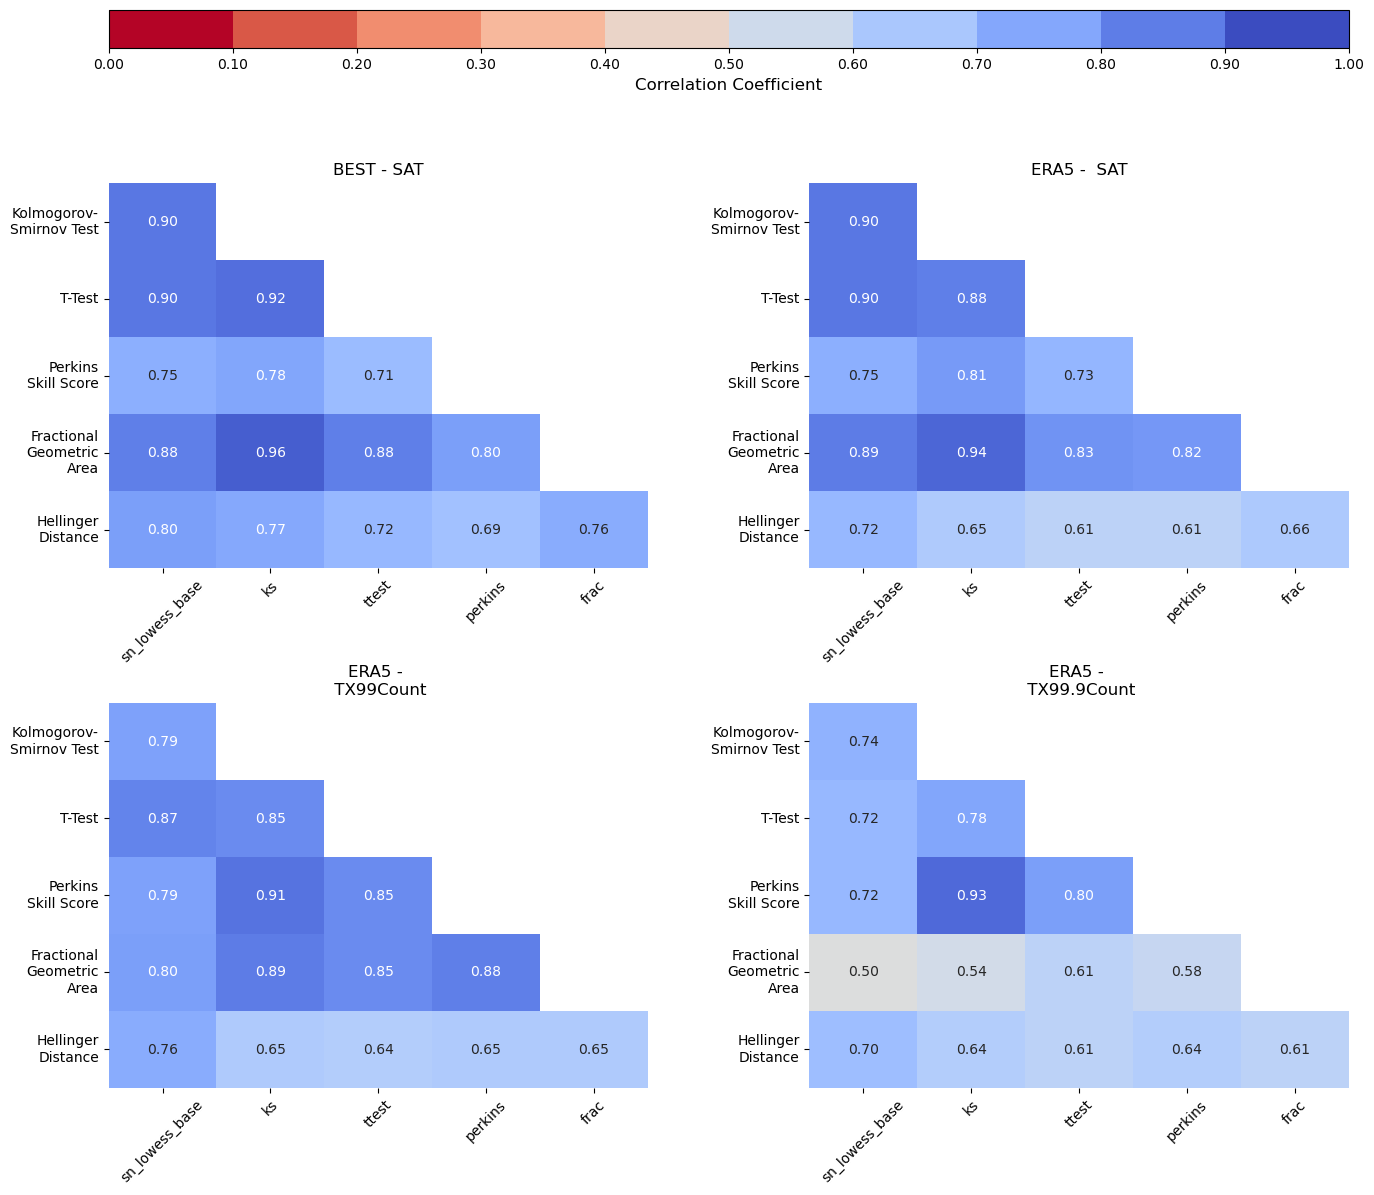

In [268]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase

# Define the discrete color levels
levels = np.arange(0, 1.1, .1)
cmap = 'coolwarm_r'  # Use the 'Blues' colormap
norm = BoundaryNorm(levels, ncolors=256)  # Create a normalization for the colorbar

# Set up the figure with gridspec for a shared colorbar
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.1, 1, 1], hspace=0.5, wspace=0.3)
cbar_ax = fig.add_subplot(gs[0, :])  # Top row for the colorbar

# Add the colorbar
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Correlation Coefficient', fontsize=12)
cbar_ax.tick_params(labelsize=10)
cb.set_ticks(levels)
cb.ax.set_xticklabels([f'{level:.2f}' for level in levels])  # Set tick labels

# Create the 2x2 grid of heatmaps
axes = [fig.add_subplot(gs[i + 1, j]) for i in range(2) for j in range(2)]  # Bottom 2 rows

# Iterate through the keys and plot each heatmap in the grid
for i, branch in enumerate(pattern_corr_tree):
    if i >= 4:  # Ensure no more than 4 heatmaps are plotted
        break
    
    ax = axes[i]  # Select the corresponding subplot
    heatmap = sns.heatmap(
        pattern_corr_tree[branch]
        .to_dataset()
        .to_pandas()
        .iloc[1:, :-1],
        annot=True,
        cmap=cmap,
        fmt='.2f',
        vmin=0,
        vmax=1,
        ax=ax,
        cbar=False  # Disable individual colorbars
    )
    
    # Change the ticks to long names
    heatmap.set_xticklabels(
        [NAME_MAPPING.get(text.get_text(), text.get_text()) for text in heatmap.get_xticklabels()]
    )
    heatmap.set_yticklabels(
        [METRIC_MAP.get(text.get_text(), text.get_text()) for text in heatmap.get_yticklabels()]
    )
    
    ax.set_title(NAME_MAPPING.get(branch, branch), fontsize=12)  # Add a title for each subplot
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # Adjust x-axis labels
    ax.tick_params(axis='y', rotation=0, labelsize=10)  # Adjust y-axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

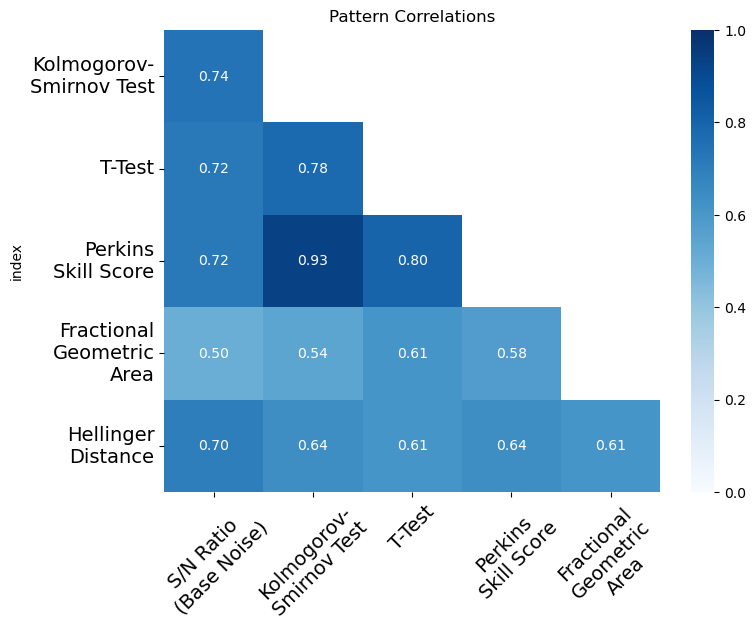

In [174]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    pattern_corr_tree['era5_tx99p9count'].to_dataset().to_pandas().iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels(
    [NAME_MAPPING.get(text.get_text(), text.get_text()) for text in heatmap.get_xticklabels()]
)
heatmap.set_yticklabels([METRIC_MAP.get(text.get_text(), text.get_text()) for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45, fontsize=14);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=14) ;  # Keep y-axis labels horizontal

<h2 style='color:cyan'> X at Y Toe </h2>

In [270]:
from scipy.stats import gaussian_kde

In [271]:
def generate_histogram(arr: np.ndarray, bins: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a histogram from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the histogram from.
    bins (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing the bin centers, the histogram values, and the histogram normalization factor.
    """
    # Remove NaN values from the input array
    vals = arr[np.isfinite(arr)]
    
    # Generate the histogram
    hist, bin_edges = np.histogram(vals, bins=bins, density=True)
    
    # Calculate the histogram normalization factor
    hist_norm = np.sum(hist)
    
    # Normalize the histogram
    hist = hist/hist_norm
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    return bin_centers, hist, hist_norm


def generate_kde(arr: np.ndarray, hist_norm: float, bin_edges: np.ndarray) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    # Normalize the KDE values
    kde_values_normalized = kde_values/hist_norm
    
    return kde_generator, kde_values_normalized

In [311]:
def plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized,
                   data, fig=None, ax=None, *args, **kwargs):
    """
    Plots a histogram and kernel density estimate (KDE) for the input data.

    Parameters:
    bin_centers (array): The bin centers for the histogram.
    histogram (array): The histogram values.
    histogram_norm (float): The normalization factor for the histogram.
    kde_generator (function): The KDE generator function.
    kde_values_normalized (array): The normalized KDE values.
    data (DataFrame): The input data.

    Returns:
    fig, ax (tuple): The figure and axis objects for the plot.
    """
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    # Plot the histogram with bars of width equal to the bin width
    # (accounting for floating point errors)
    ax.bar(bin_centers, histogram, width=np.unique(np.diff(bin_centers))[0].round(2), alpha=0.5)
    
    # Generate x values for the KDE plot
    x_grid = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    
    # Plot the KDE
    ax.plot(x_grid, kde_values_normalized, label='KDE', color='black')
    
    # Set the axis labels and title
    ax.set_ylabel('Relative Frequency', fontsize=20)
    ax.set_xlabel(kwargs.get('xlabel','Value'))
    ax.grid(True, alpha=0.3, color='grey', linestyle='--')

    # Calculate and plot the quantiles
    quantiles = {}
    percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    for q in percentiles:
        qval = np.nanpercentile(data, q*100).round(2).item()
        quantiles[q] = qval
        rf_val = kde_generator(qval).item()/ histogram_norm
        if q==0.5: style_dict = dict(linewidth=3, color='k')
        elif q==0.25 or q==0.75: style_dict = dict(linewidth=2, color='k', linestyle='--')
        elif q ==percentiles[0] or q==percentiles[-1]: style_dict = dict(linewidth=2, color='k', linestyle=':')

        # Plot the quantiles as vertical lines
        ax.plot([qval, qval], [0, rf_val], **style_dict)

        # round_number = lambda n: round(n - 0.05) if n % 10 != 0 else round(n)
        # ax.annotate(round_number(qval), xy=(qval+0.025*np.max(bincenters), 0),
        #             size=16, ha='center')

    # print(quantiles)
    
    return fig, ax

In [319]:
def calculate_and_plot_histogram(data, bins, fig=None, ax=None, **kwargs):
    """
    Plots the distribution of values.

    Parameters:
    data (array-like): The data to plot.
    bins (array-like): The bins for the histogram.
    xlabel (str, optional): The label for the x-axis. Defaults to 'Distribution Overlap (%)'.

    Returns:
    fig, ax: The figure and axis objects for the plot.
    """
    bin_centers, histogram, histogram_norm = generate_histogram(data.flatten(), bins)
    kde_generator, kde_values_normalized = generate_kde(data.flatten(), histogram_norm, bin_centers)
    fig, ax = plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized, 
                             data, fig=fig, ax=ax)
    
    # ax.set_title(kwargs.get('title', ''), fontsize=25)
    # ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=20)

    return fig, ax

In [304]:
BINS = {
    'sn': np.arange(-0.5, 2.5, .03),
    'overlap':np.arange(0, 101, 1)
}

In [305]:
xaty_ds = x_at_y_emergence_tree['best_tas'].to_dataset()

In [313]:
banned_xandy = ['sn_lowess_full', 'hawkins']

In [314]:
good_xandy = [m for m in list(xaty_ds) if not np.any([bm in m for bm in banned_xandy])]
good_xandy

['frac_at_hd_emergence',
 'frac_at_ks_emergence',
 'frac_at_perkins_emergence',
 'frac_at_sn_lowess_base_emergence',
 'frac_at_ttest_emergence',
 'hd_at_frac_emergence',
 'hd_at_ks_emergence',
 'hd_at_perkins_emergence',
 'hd_at_sn_lowess_base_emergence',
 'hd_at_ttest_emergence',
 'perkins_at_frac_emergence',
 'perkins_at_hd_emergence',
 'perkins_at_ks_emergence',
 'perkins_at_sn_lowess_base_emergence',
 'perkins_at_ttest_emergence',
 'sn_lowess_base_at_frac_emergence',
 'sn_lowess_base_at_hd_emergence',
 'sn_lowess_base_at_ks_emergence',
 'sn_lowess_base_at_perkins_emergence',
 'sn_lowess_base_at_ttest_emergence']

In [315]:
xaty_ds = xaty_ds[good_xandy]

In [ ]:
metrics

In [ ]:
COL_CONTROL_DICT = {
    'sn_lowess_base': 0,
    '
}

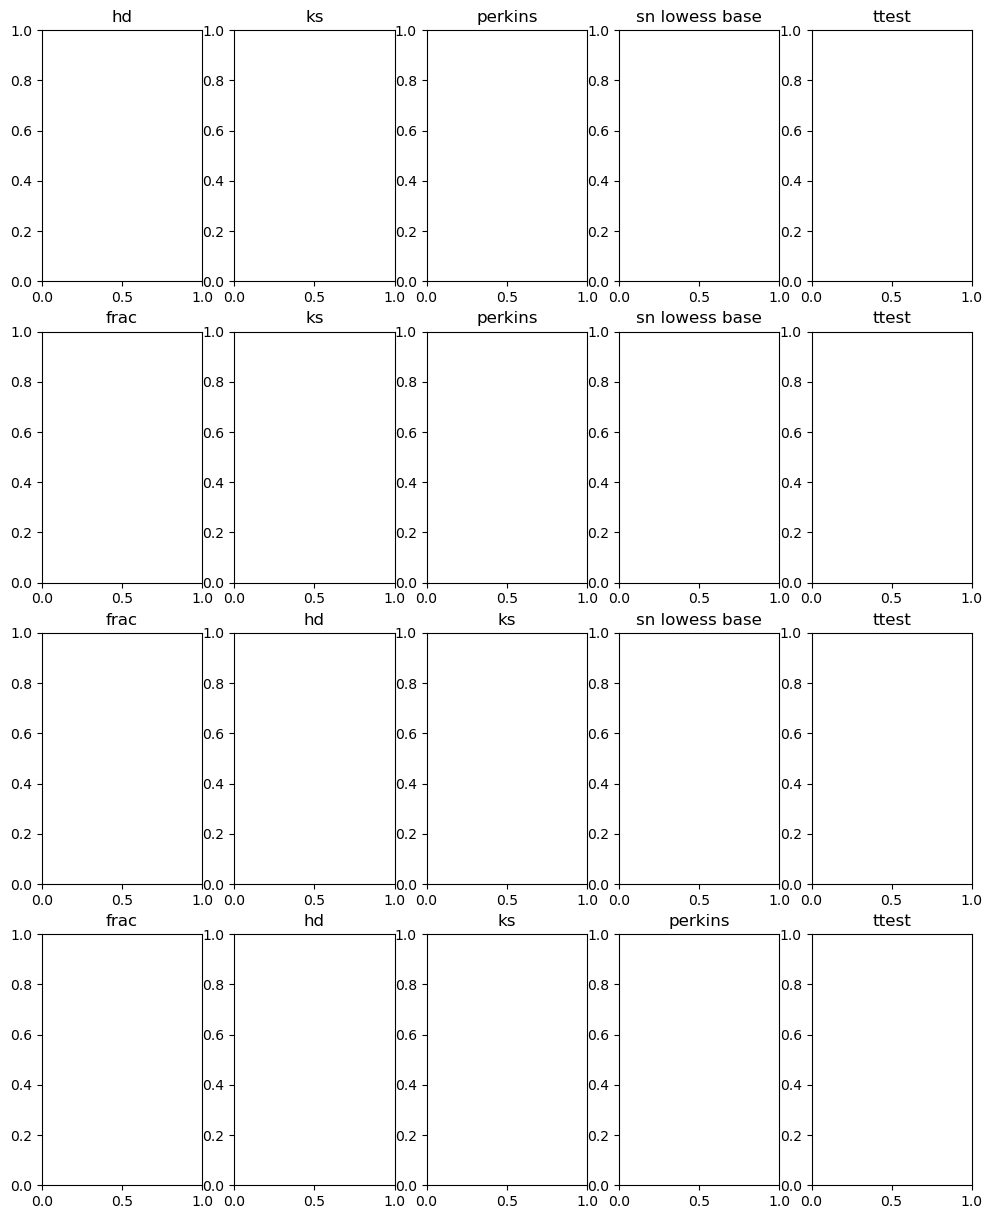

In [321]:
nrows = 5
nrows = 4

fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(nrows, ncols)
axes = [fig.add_subplot(gs[i]) for i in range(ncols*nrows)]


row = 0
col = 0
for num, xaty_var in enumerate(xaty_ds):
    ax = axes[num]
    main_met = xaty_var.split('_')[0]
    if num != 0:
        if main_met != list(xaty_ds)[num-1].split('_')[0]:
            row += 1
            col = 0
    
    if main_met == 'sn': bins = BINS['sn']
    else: bins = BINS['overlap']

    # xaty_da = xaty_ds[xaty_var].squeeze()
    # calculate_and_plot_histogram(
    #      np.abs(xaty_da.values), bins, title=xaty_var,
    # fig=fig, ax=ax)
    other_var = xaty_var.split('_at_')[-1].split('_emergence')[0].replace('_', ' ')
    ax.set_title()
    
    col += 1

In [287]:
xaty_da = x_at_y_emergence_tree['best_tas'].to_dataset()['sn_lowess_base_at_perkins_emergence']

{0.05: 0.42, 0.25: 0.85, 0.5: 1.04, 0.75: 1.22, 0.95: 1.49}


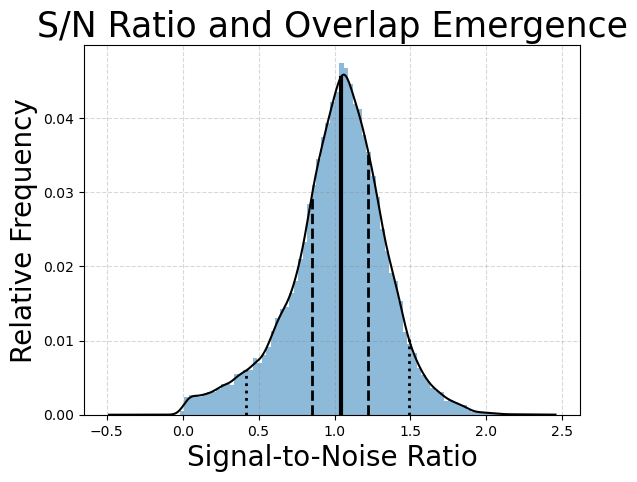

In [290]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(
    np.abs(xaty_da.values), snr_bins, 
    title='S/N Ratio and Overlap Emergence', xlabel='Signal-to-Noise Ratio')

In [ ]:
bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_sn_lowess_emergence_ds.values, bins, 
                           title='Overlap at S/N Ratio Emergence', xlabel='Distribution Overlap (%)')

# Exploring Locations

In [94]:
location = dict(lat=-15, lon=-15, method='nearest')

In [95]:
data_ds_loc = data_tree.era5_tx99count.tx99count.sel(**location)
toe_metric_ds_loc = toe_metric_tree.era5_tx99count.perkins.sel(**location)
base_peridod_ds_loc = data_ds_loc.where(data_ds_loc.time.dt.year.isin(np.arange(base_period.start, base_period.end)), drop=True)

In [96]:
base_peridod_ds_loc.values

array([20.33333333, -1.66666667, -3.66666667, -3.66666667, -3.66666667,
       -3.66666667, -3.66666667, -2.66666667, -0.66666667,  3.33333333,
       -3.66666667, -3.66666667, -3.66666667, -0.66666667, -3.66666667,
       -3.66666667, -3.66666667, -3.66666667, -3.66666667,  1.33333333,
       -3.66666667, -1.66666667, -1.66666667, 12.33333333,  3.33333333,
        8.33333333, -0.66666667, -3.66666667, -3.66666667, 19.33333333])

In [97]:
start, step, stop = toe_metric_ds_loc.bins.values()
start, step, stop 

(-4.11, 4.11, 361.6835)

In [98]:
bins = np.arange(start, stop, step)

In [99]:
base_period

<YearRange.ERA5_START: (1940, 1970)>

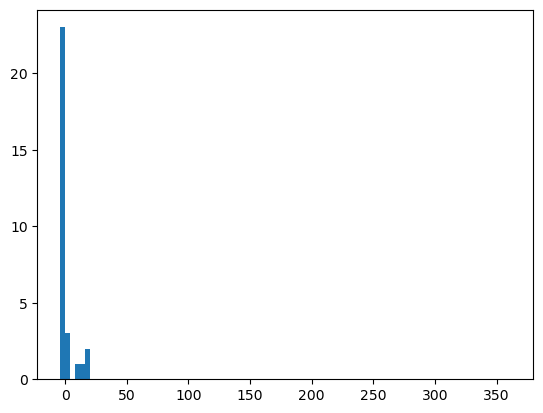

In [100]:
plt.hist(base_peridod_ds_loc.values, bins);

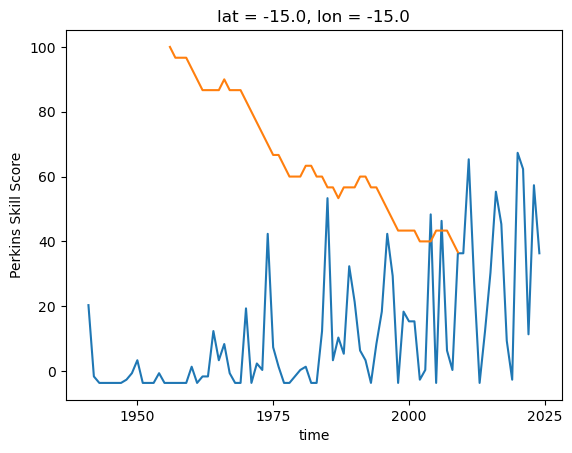

In [101]:
data_ds_loc.plot()
toe_metric_ds_loc.plot()

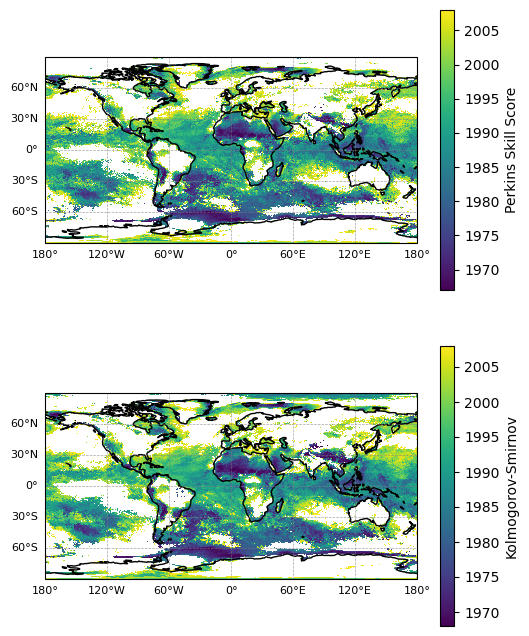

In [102]:
fig = plt.figure(figsize=(6, 8))
axes = [fig.add_subplot(2, 1, i, projection=ccrs.PlateCarree()) for i in np.arange(1, 3)]
toe_tree.era5_tx99count.perkins.plot(ax=axes[0])
toe_tree.era5_tx99count.ks.plot(ax=axes[1])

for ax in axes:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False  # Disable latitude labels on the top border
    gl.right_labels = False  # Disable longitude labels on the right border
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}

# Defunct (Using ACCESS)

In [ ]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_tas', 'era5_t2m', 'era5_cape']#'access_ssp585_r10i1p1f1_pr_QSDEC']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), len(tests_var_used) +2, 
                       width_ratios = [1, 1, 0.1, 1, 0.1])


cmap1 = plt.cm.YlOrRd
cmap2 = plt.cm.PuBu

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0, 1, 3]]
    for row in range(len(tests_subset_used))
])

caxes = [plt.subplot(gs[:, col]) for col in [2, 4]]

for col,variable in enumerate(list(tests_var_used)):


    
    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap=cmap1, ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap=cmap2, ax=ax, **toe_plot_kwargs)
        # toe_plot = toe_tree[variable].to_dataset()[test].plot(ax=ax, **toe_plot_kwargs)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14)
            
        if row == 0: ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14)


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    cmap1, PLOT_LEVELS['best_tas'].generate_range(), caxes1[0], '')
cbar2 = create_discrete_colorbar(
    cmap2, PLOT_LEVELS['best_tas'].generate_range(), caxes1[1], 'Time of Emergence',
    fontscale=fontscale)

cbar1.ax.set_yticks([]);

In [ ]:
list(toe_tree)

In [ ]:
list(toe_tree.best_tas)

In [ ]:
fontscale = 1.4
tests_subset_used = ['sn_lowess_base', 'ks', 'frac'] # sn_lowess_full#, 'perkins', 'hd']
tests_var_used = [
    'best_tas', 'era5_t2m', 'era5_cape']
    # 'access_ssp585_r10i1p1f1_pr_QSDEC']
# 'access_ssp585_r10i1p1f1_tasmax'

# cax_locs = [3, 4, 7, 8] # location of cax
cax_locs = [3, 5] # location of cax
num_cols = len(tests_var_used) + len(cax_locs) # num plots + num cax
# width ratio configuration
width_ratios = np.ones(num_cols) 
width_ratios[cax_locs] = 0.2
plot_locs = np.where(width_ratios == 1)[0]

fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), num_cols, width_ratios = width_ratios)

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in plot_locs]
    for row in range(len(tests_subset_used))
])

# Define the colormap
toe_cmap = plt.cm.RdYlBu

for col,variable in enumerate(list(tests_var_used)):

    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels) # cmap=toe_cmap,

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap='YlOrRd', ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap='PuBu', ax=ax, **toe_plot_kwargs)

        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14*fontscale)
            
        if row == 0: 
            ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14*fontscale)
        else:
            ax.set_title('')


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['best_tas'].generate_range(), caxes1[0], '')
cbar2 = create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['best_tas'].generate_range(), caxes1[1], 'Time of Emergence',
    fontscale=fontscale)


cax_gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[-1]], wspace=0)
caxes2 = [plt.subplot(cax_gs2[:, i]) for i in [0, 1]]

# Create colorbars
cbar3 = create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[0], '')

cbar4 = create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[1], 'Time of Emergence', 
    fontscale=fontscale)

cbar3.ax.set_yticks([]);
cbar1.ax.set_yticks([]);

    import logging


In [ ]:
tests_subset_used = ['sn_lowess_base', 'ks', 'frac'] # sn_lowess_full#, 'perkins', 'hd']
tests_var_used = [
    'best_tas', 'era5_t2m', 'era5_cape']
    # 'access_ssp585_r10i1p1f1_pr_QSDEC', 'access_ssp585_r10i1p1f1_tas']
# 'access_ssp585_r10i1p1f1_tasmax'

# cax_locs = [3, 4, 7, 8] # location of cax
cax_locs = [3, 6] # location of cax
num_cols = len(tests_var_used) + len(cax_locs) # num plots + num cax
# width ratio configuration
width_ratios = np.ones(num_cols) 
width_ratios[cax_locs] = 0.2
plot_locs = np.where(width_ratios == 1)[0]

fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), num_cols, width_ratios = width_ratios)

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in plot_locs]
    for row in range(len(tests_subset_used))
])

# Define the colormap
toe_cmap = plt.cm.RdYlBu

for col,variable in enumerate(list(tests_var_used)):

    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels) # cmap=toe_cmap,

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap='YlOrRd', ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap='PuBu', ax=ax, **toe_plot_kwargs)

        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14)
            
        if row == 0: 
            ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14)
        else:
            ax.set_title('')


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['best_tas'].generate_range(), caxes1[0], '')
create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['best_tas'].generate_range(), caxes1[1], 'Time of Emergence')


cax_gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[-1]], wspace=0)
caxes2 = [plt.subplot(cax_gs2[:, i]) for i in [0, 1]]

# Create colorbars
create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[0], '')
create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[1], 'Time of Emergence')
